# Imports

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Classifying Handwritten Digits with a Neural Network (NN)

### Importing MNIST Image Data

In [7]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

X = X.values
y = y.astype(int).values

total_images, pixels_per_image = X.shape
total_class_labels, *_ = y.shape

print(f'Total Images: {total_images}')
print(f'Total Pixels Per Image: {pixels_per_image}')
print(f'Total Class Labels: {total_class_labels}')

''' verify dimensions and total pixels '''
assert total_images == total_class_labels
assert pixels_per_image == 784

Total Images: 70000
Total Pixels Per Image: 784
Total Class Labels: 70000


### Normalizing Pixel Values from 0-255 range to -1-1 (negative one to one)

In [8]:
X = ((X / 255.) - .5) * 2

### Visualizing Digit Examples from MNIST

#### Visualizing 0-9

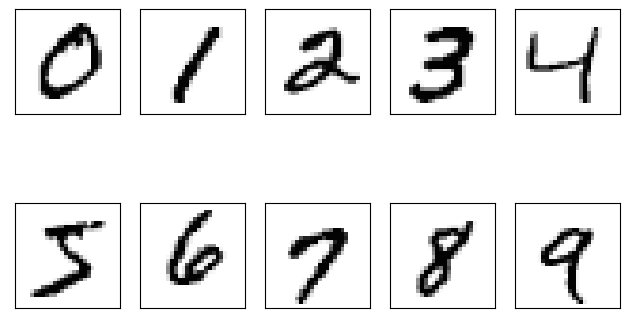

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img = X[y == i][0].reshape(28, 28) # each image has 784 pixels, but they're actually 28x28 pixel images
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

#### Visualizing all examples for 7

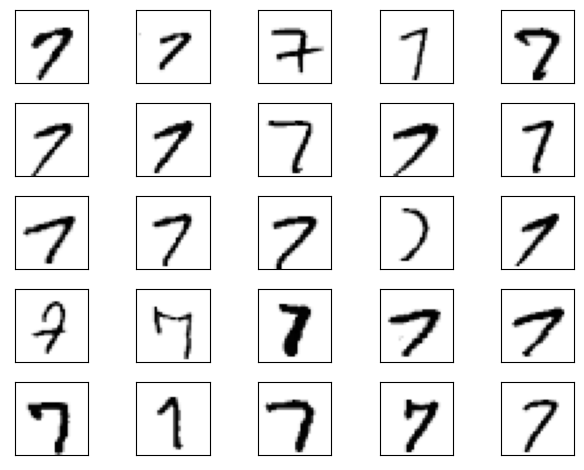

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

### Split the dataset into training, validation, and test subsets

In [17]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

### Implementing a Multi-layer Perceptron (MLP)

In [15]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    arr = np.zeros((y.shape[0], num_labels))
    
    for i, val in enumerate(y):
        arr[i, val] = 1
    
    return arr

class NeuralNetMLP:
    
    def __init__(
        self, 
        num_features : int, 
        num_hidden : int, 
        num_classes : int, 
        random_seed : int = 123
    ) -> None :
        
        self.num_classes = num_classes
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features)
        )
        
        self.bias_h = np.zeros(num_hidden)
        
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden)
        )
        
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, X : np.ndarray) -> tuple[np.ndarray] :
        
        z_h = np.dot(X, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        
        return a_h, a_out
    
    def backward(
        self, 
        X : np.ndarray, 
        a_h : np.ndarray, 
        a_out : np.ndarray, 
        y : np.ndarray
    ) -> tuple[np.ndarray] :
        
        y_onehot = int_to_onehot(y, self.num_classes)
        
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out) #sigmoid derivative
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        
        d_z_out__dw_out = a_h
        
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        d_z_out__a_h = self.weight_out
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        d_a_h__d_z_h = a_h * (1. - a_h) #sigmoid derivative
        d_z_h__d_w_h = X
        
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)
        
        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)

### Constructing the NN training loop

In [25]:
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X : np.ndarray, y : np.ndarray, minibatch_size : int):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx : start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

def mse_loss(targets : np.ndarray, probas : np.ndarray, num_labels : int = 10):
    onehot_targets = int_to_onehot(targets, num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets : np.ndarray, predicted_labels : np.ndarray):
    return np.mean(predicted_labels == targets)
    
''' testing minibatch gen '''
# for i in range(num_epochs):
#     minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
#     for X_train_mini, y_train_mini in minibatch_gen:
#         pass
    
# print(X_train_mini.shape)
# print(y_train_mini.shape)

model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial Validation MSE: {mse:.1f}')
print(f'Initial Validation Accuracy: {acc*100:.1f}%')

Initial Validation MSE: 0.3
Initial Validation Accuracy: 9.4%
